## Data Loading and Preprocessing

In [ ]:
import sys, pandas as pd
print(sys.version)
print("pandas:", pd.__version__) # Check pandas version

3.12.9 | packaged by conda-forge | (main, Feb 14 2025, 08:00:06) [GCC 13.3.0]
pandas: 2.3.3


In [ ]:
%pip -q install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#Download CPI from FRED and standardize the column name
import pandas_datareader.data as web
import pandas as pd

SERIES = "CPIAUCSL"          # CPI for All Urban Consumers (monthly)
START  = "1990-01-01"

# Download data from FRED
df = web.DataReader(SERIES, "fred", START).dropna()
df = df.rename(columns={SERIES: "y"}) 
df.head(), df.tail(), df.shape 

(                y
 DATE             
 1990-01-01  127.5
 1990-02-01  128.0
 1990-03-01  128.6
 1990-04-01  128.9
 1990-05-01  129.1,
                   y
 DATE               
 2025-06-01  321.500
 2025-07-01  322.132
 2025-08-01  323.364
 2025-09-01  324.368
 2025-11-01  325.031,
 (430, 1))

In [5]:
#Force a clean monthly index and fill any gaps
df = df.asfreq("MS")
df["y"] = df["y"].ffill()

TEST_PERIODS = 24
train = df.iloc[:-TEST_PERIODS].copy()
test  = df.iloc[-TEST_PERIODS:].copy()

print("df freq:", df.index.freqstr)
print("train last:", train.index.max(), "test first:", test.index.min())
print("Any NaNs in df?", df["y"].isna().any())

df freq: MS
train last: 2023-11-01 00:00:00 test first: 2023-12-01 00:00:00
Any NaNs in df? False


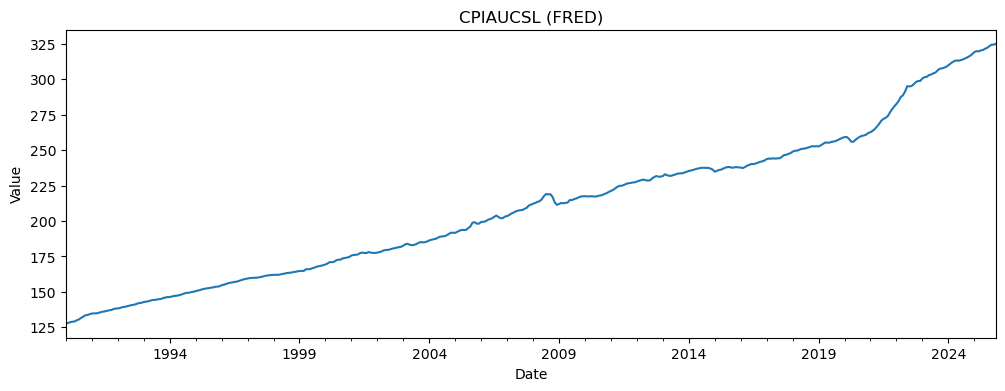

In [ ]:
# Plot the data
import matplotlib.pyplot as plt

ax = df["y"].plot(figsize=(12,4), title=f"{SERIES} (FRED)")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
plt.show()

In [ ]:
# Time-based train/test split i.e. last 24 months
import numpy as np

TEST_PERIODS = 24

train = df.iloc[:-TEST_PERIODS].copy()
test  = df.iloc[-TEST_PERIODS:].copy()

print("Train:", train.index.min().date(), "->", train.index.max().date(), "rows:", len(train))
print("Test :", test.index.min().date(),  "->", test.index.max().date(),  "rows:", len(test))

Train: 1990-01-01 -> 2023-11-01 rows: 407
Test : 2023-12-01 -> 2025-11-01 rows: 24


## Baseline Model: ARIMA

In [9]:
# Import ARIMA
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Fit ARIMA on Training Data
model = ARIMA(train["y"], order=(1,1,1))
arima_fit = model.fit()

print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  407
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -348.088
Date:                Thu, 01 Jan 2026   AIC                            702.175
Time:                        00:31:46   BIC                            714.194
Sample:                    01-01-1990   HQIC                           706.932
                         - 11-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6538      0.033     19.689      0.000       0.589       0.719
ma.L1          0.0373      0.048      0.781      0.435      -0.056       0.131
sigma2         0.3248      0.014     23.042      0.0

In [ ]:
# Generate forecasts for the test period
forecast = arima_fit.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)
forecast.head()

DATE
2023-12-01    308.380890
2024-01-01    308.573041
2024-02-01    308.698674
2024-03-01    308.780815
2024-04-01    308.834521
Freq: MS, Name: predicted_mean, dtype: float64

In [ ]:
# Evaluate Performance for ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_forecast(y_true, y_pred, label="model"):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label} MAE : {mae:.3f}")
    print(f"{label} RMSE: {rmse:.3f}")
    return mae, rmse

fc = arima_fit.get_forecast(steps=len(test))
forecast = fc.predicted_mean
forecast.index = test.index

arima_mae, arima_rmse = evaluate_forecast(
    test["y"].to_numpy(),
    forecast.to_numpy(),
    label="ARIMA(1,1,1)"
)

ARIMA(1,1,1) MAE : 8.350
ARIMA(1,1,1) RMSE: 9.589


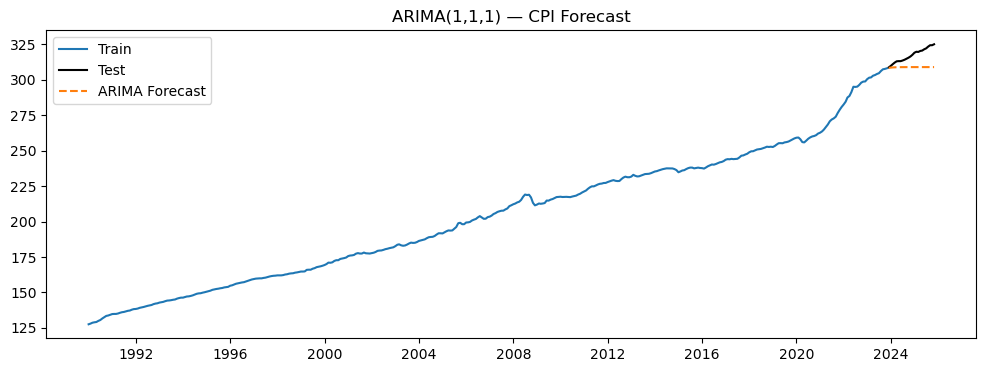

In [ ]:
# Plot: train vs test vs forecast results
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(train.index, train["y"], label="Train")
plt.plot(test.index, test["y"], label="Test", color="black")
plt.plot(forecast.index, forecast, label="ARIMA Forecast", linestyle="--")
plt.legend()
plt.title("ARIMA(1,1,1) — CPI Forecast")
plt.show()

In [ ]:
# Create a comparative results table
results = pd.DataFrame(columns=[
    "model",
    "mae",
    "rmse",
    "train_end",
    "test_start",
    "test_end"
])

results

,model,mae,rmse,train_end,test_start,test_end


In [ ]:
# then add ARIMA Results
results.loc[len(results)] = [
    "ARIMA(1,1,1)",
    float(arima_mae),
    float(arima_rmse),
    train.index.max(),
    test.index.min(),
    test.index.max()
]

results

,model,mae,rmse,train_end,test_start,test_end
0,"ARIMA(1,1,1)",8.349561,9.589298,2023-11-01,2023-12-01,2025-11-01


## Trend-Based Model: Prophet

In [17]:
%pip -q install prophet

Note: you may need to restart the kernel to use updated packages.


In [18]:
from prophet import Prophet

In [ ]:
# Prepare data in prophet format
prophet_df = df.reset_index().rename(columns={"DATE": "ds", "y": "y"})
prophet_train = train.reset_index().rename(columns={"DATE": "ds", "y": "y"})
prophet_test  = test.reset_index().rename(columns={"DATE": "ds", "y": "y"})

prophet_train.head(), prophet_test.head()

(          ds      y
 0 1990-01-01  127.5
 1 1990-02-01  128.0
 2 1990-03-01  128.6
 3 1990-04-01  128.9
 4 1990-05-01  129.1,
           ds        y
 0 2023-12-01  308.735
 1 2024-01-01  309.794
 2 2024-02-01  311.022
 3 2024-03-01  312.107
 4 2024-04-01  313.016)

In [ ]:
# Fit prophet model
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)
m.fit(prophet_train) 

00:33:03 - cmdstanpy - INFO - Chain [1] start processing
00:33:03 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Forcast test dates
future = prophet_test[["ds"]].copy()
pred = m.predict(future)

prophet_forecast = pred.set_index("ds")["yhat"]
prophet_forecast.index = pd.to_datetime(prophet_forecast.index)

prophet_forecast.head(), prophet_forecast.tail()

(ds
 2023-12-01    300.424402
 2024-01-01    301.178425
 2024-02-01    301.805678
 2024-03-01    302.814798
 2024-04-01    303.406347
 Name: yhat, dtype: float64,
 ds
 2025-07-01    315.315116
 2025-08-01    316.112775
 2025-09-01    317.049564
 2025-10-01    317.731102
 2025-11-01    318.230067
 Name: yhat, dtype: float64)

In [ ]:
# Evaluate Performance for Prophet
future = prophet_test[["ds"]].copy()
pred = m.predict(future)

prophet_forecast = pred.set_index("ds")["yhat"] # Get the forecasted values
prophet_forecast.index = pd.to_datetime(prophet_forecast.index) 

prophet_forecast.head(), prophet_forecast.tail()

prophet_mae, prophet_rmse = evaluate_forecast(
    test["y"].to_numpy(),
    prophet_forecast.reindex(test.index).to_numpy(),
    label="Prophet"
)

Prophet MAE : 7.776
Prophet RMSE: 7.824


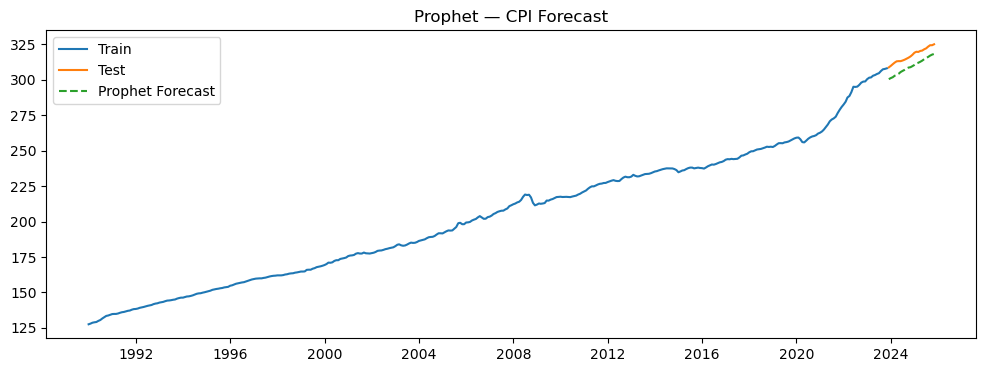

In [ ]:
# Plot Comparison of forcast
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(train.index, train["y"], label="Train")
plt.plot(test.index, test["y"], label="Test")
plt.plot(prophet_forecast.index, prophet_forecast, label="Prophet Forecast", linestyle="--")
plt.legend()
plt.title("Prophet — CPI Forecast")
plt.show()

In [ ]:
# Add prophet to results table 
results.loc[len(results)] = [
    "Prophet",
    float(prophet_mae),
    float(prophet_rmse),
    train.index.max(),
    test.index.min(),
    test.index.max()
]
results.sort_values("rmse") #  to sort by rmse

,model,mae,rmse,train_end,test_start,test_end
1,Prophet,7.775770,7.823538,2023-11-01,2023-12-01,2025-11-01
0,"ARIMA(1,1,1)",8.349561,9.589298,2023-11-01,2023-12-01,2025-11-01


## Deep Learning Model: LSTM

In [26]:
# build supervised window
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

LOOKBACK = 24  # 24 months history -> next month

# Fit scaler on TRAIN ONLY to avoid leakage
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[["y"]]).astype(np.float32)
test_scaled  = scaler.transform(test[["y"]]).astype(np.float32)

# For test windows, we need the last LOOKBACK points of train + all test
full_scaled = np.vstack([train_scaled, test_scaled]).astype(np.float32)

def make_windows(series_2d, lookback, start_idx, end_idx):
    # series_2d shape: (N, 1)
    X, y = [], []
    for i in range(start_idx, end_idx):
        X.append(series_2d[i-lookback:i, 0])
        y.append(series_2d[i, 0])
    X = np.array(X, dtype=np.float32)[..., None]  # (samples, lookback, 1)
    y = np.array(y, dtype=np.float32)             # (samples,)
    return X, y

# Train windows: indices within train_scaled
X_train, y_train = make_windows(train_scaled, LOOKBACK, LOOKBACK, len(train_scaled))

# Test windows: predict each test point using preceding LOOKBACK points (includes tail of train)
test_start_in_full = len(train_scaled)  # first test point position in full_scaled
X_test, y_test = make_windows(full_scaled, LOOKBACK, test_start_in_full, len(full_scaled))

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)


X_train: (383, 24, 1) y_train: (383,)
X_test : (24, 24, 1) y_test : (24,)


In [27]:
# Define and train LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(42)

model = keras.Sequential([
    layers.Input(shape=(LOOKBACK, 1)),
    layers.LSTM(32),
    layers.Dense(16, activation="relu"),
    layers.Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5)
]

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


2026-01-01 00:33:46.804823: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.1384 - val_loss: 0.3252 - learning_rate: 0.0010
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0300 - val_loss: 0.0180 - learning_rate: 0.0010
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0090 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0039 - val_loss: 0.0342 - learning_rate: 0.0010
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0033 - val_loss: 0.0145 - learning_rate: 0.0010
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.2900e-04 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.2100e-04 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 9/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.9371e-04 - val_loss: 0.0011 - learning_rate: 0.001

In [ ]:
# Predict and Invert scaling back to CPI units...
pred_scaled = model.predict(X_test).reshape(-1, 1)

pred = scaler.inverse_transform(pred_scaled).reshape(-1)
actual = test["y"].to_numpy()

lstm_forecast = pd.Series(pred, index=test.index)

lstm_forecast.head(), lstm_forecast.tail()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


(DATE
 2023-12-01    306.300507
 2024-01-01    307.028259
 2024-02-01    307.770447
 2024-03-01    308.540802
 2024-04-01    309.322113
 Freq: MS, dtype: float32,
 DATE
 2025-07-01    318.527893
 2025-08-01    319.083862
 2025-09-01    319.694702
 2025-10-01    320.325409
 2025-11-01    320.876923
 Freq: MS, dtype: float32)

In [ ]:
# Evaluate LSTM vs priomodels 
lstm_mae, lstm_rmse = evaluate_forecast(
    actual,
    lstm_forecast.to_numpy(),
    label="LSTM"
)

LSTM MAE : 3.293
LSTM RMSE: 3.374


## Model Comparison/Results Table

In [31]:
# Add to results table + view ranking
results.loc[len(results)] = [
    "LSTM(lookback=24)",
    float(lstm_mae),
    float(lstm_rmse),
    train.index.max(),
    test.index.min(),
    test.index.max()
]

results.sort_values("rmse").reset_index(drop=True)

,model,mae,rmse,train_end,test_start,test_end
0,LSTM(lookback=24),3.293428,3.374313,2023-11-01,2023-12-01,2025-11-01
1,Prophet,7.775770,7.823538,2023-11-01,2023-12-01,2025-11-01
2,"ARIMA(1,1,1)",8.349561,9.589298,2023-11-01,2023-12-01,2025-11-01


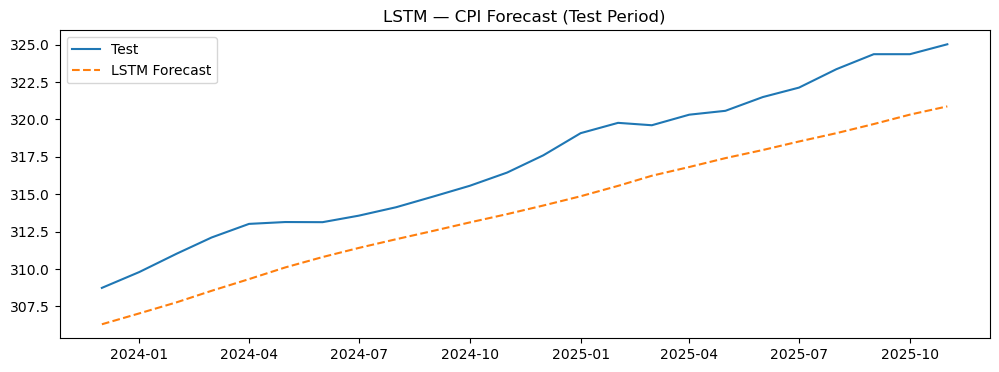

In [32]:
# Plot test vs LSTM Forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(test.index, test["y"], label="Test")
plt.plot(lstm_forecast.index, lstm_forecast, label="LSTM Forecast", linestyle="--")
plt.legend()
plt.title("LSTM — CPI Forecast (Test Period)")
plt.show()

In [33]:
# Confirm fitted prophet model
type(m)

prophet.forecaster.Prophet

## Model Serialization and Packaging

In [34]:
#save to disk
import os, pickle

MODEL_DIR = "model_artifacts/prophet"
os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_PATH = os.path.join(MODEL_DIR, "model.pkl")
with open(MODEL_PATH, "wb") as f:
    pickle.dump(m, f)

print("Saved to:", MODEL_PATH)
print("File exists?", os.path.exists(MODEL_PATH))
print("File size (bytes):", os.path.getsize(MODEL_PATH))

Saved to: model_artifacts/prophet/model.pkl
File exists? True
File size (bytes): 44809


In [ ]:
import pandas as pd

def prophet_predict(model, ds_list):
    df_in = pd.DataFrame({"ds": pd.to_datetime(ds_list)})
    out = model.predict(df_in)
    return out[["ds", "yhat", "yhat_lower", "yhat_upper"]]

# test on your test period dates
local_pred = prophet_predict(m, test.index)
local_pred.head()

,ds,yhat,yhat_lower,yhat_upper
0,2023-12-01,300.424402,295.766993,304.298188
1,2024-01-01,301.178425,297.062547,305.474150
2,2024-02-01,301.805678,297.857167,306.199589
3,2024-03-01,302.814798,298.782753,307.143865
4,2024-04-01,303.406347,299.020130,307.528293


In [36]:
# Package model
import tarfile

TARBALL_PATH = "prophet-model.tar.gz"

with tarfile.open(TARBALL_PATH, "w:gz") as tar:
    tar.add(MODEL_PATH, arcname="model.pkl")

print("Created:", TARBALL_PATH)
print("Size (bytes):", os.path.getsize(TARBALL_PATH))

Created: prophet-model.tar.gz
Size (bytes): 20495


## Model Selection and Conclusions
Among the evaluated models (ARIMA, Prophet, and LSTM), Prophet achieved the best performance on a 24-month holdout set, producing the lowest MAE and RMSE. This reflects the trend-dominated nature of CPI data, where models explicitly designed for trend and seasonality can outperform more complex deep learning approaches in a univariate setting.
The selected Prophet model was serialized and packaged in a SageMaker-compatible format, with a custom inference handler implemented to support deployment. Deployment code is provided separately and intentionally excluded from the notebook to avoid unintended cloud costs.
This analysis is limited to univariate CPI level forecasting and does not incorporate exogenous macroeconomic variables (e.g., interest rates, unemployment, energy prices). Future work could extend the model to multivariate settings, alternative targets such as inflation rates, and longer forecast horizons.
Overall, this project demonstrates a reproducible, cost-aware workflow for economic time-series forecasting, combining sound model evaluation with practical deployment considerations.